In [1]:
import warnings
warnings.simplefilter("ignore")
import os
srt_dir = os.getcwd()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all') # can be commented out, this just closes any previously generated graphics


#Comment next line in to CHANGE TO WHERE THE PSDM IS STORED ON YOUR MACHINE
# os.chdir('../')
import PSDM.PSDM as PSDM
os.chdir(srt_dir)

In [2]:
# =============================================================================
# Define the File to analyze
# can be in different folder, must be explicit for file location or can 
# use referential convention '../data/filename.xlsx' or 'C:/folders.../filename'
# =============================================================================
fn = 'Example_Multi.xlsx'

# =============================================================================
# READ IN Chemical Property Information
# may need to change location of file, depending on where it is stored locally
# properties are included in 'fn' from above, but can be separate file as well
# =============================================================================
chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data

# =============================================================================
# Read in Input File
# Can change location of data_sheet= and column_sheet= to match file naming
# =============================================================================
raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )


Starting example multicomponent simulation
 This may take several minutes
Starting example multicomponent simulation
 This may take several minutes


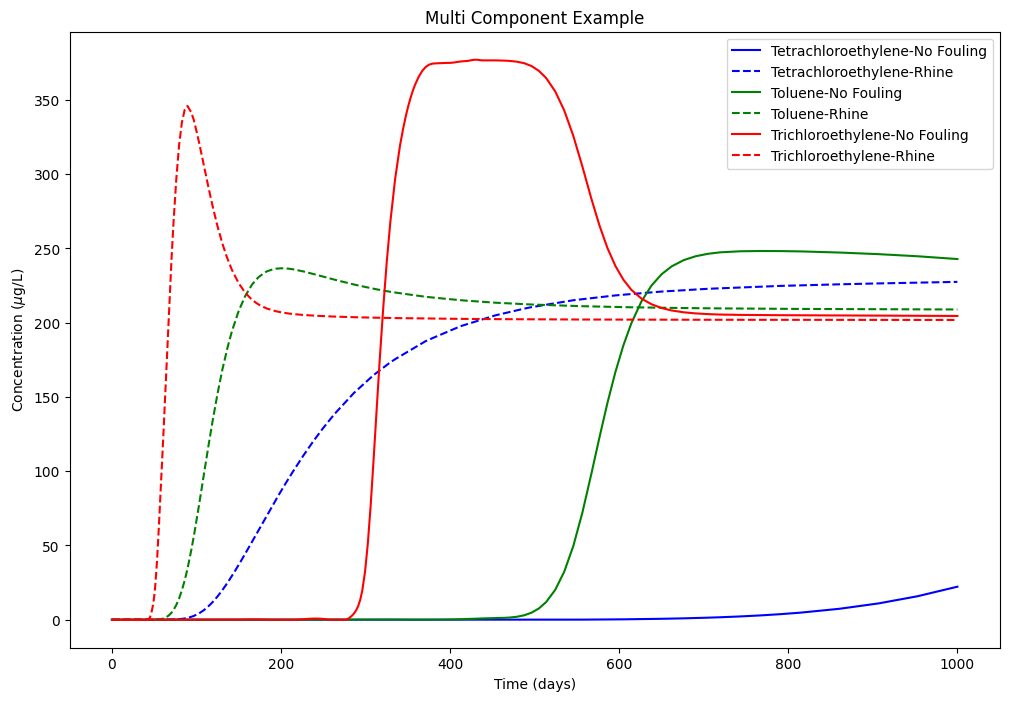

In [3]:
# =============================================================================
# Multi Component - No Fouling    
# =============================================================================
    
water_type = 'Organic Free'
chem_type = 'halogenated alkenes'

nr=4
nz=8
ne=2

column = PSDM.PSDM(column_info[carbons[0]], chem_data, raw_data,\
                         nz=nz,\
                         nr=nr,\
                         ne=ne,\
                         chem_type=chem_type,\
                         water_type=water_type,\
                         k_data=k_data,\
                         solver='BDF')
    
print('Starting example multicomponent simulation\n', 'This may take several minutes')

all_results = column.run_psdm()


# =============================================================================
# Multi Component - Fouling Example
# NOTE: For complex competitive systems, you can use nz=3, ne=20 (or higher for ne)
# By using nz=3, and controlling collocation with ne, you get a case that 
# treats the simulation more like a finite element, rather than collocation
# =============================================================================


water_type = 'Rhine'
chem_type = 'halogenated alkanes'

nr=4
nz=8
ne=2

column = PSDM.PSDM(column_info[carbons[0]], chem_data, raw_data,\
                         nz=nz,\
                         nr=nr,\
                         ne=ne,\
                         chem_type=chem_type,\
                         water_type=water_type,\
                         k_data=k_data,\
                         solver='BDF')
    
print('Starting example multicomponent simulation\n', 'This may take several minutes')

all_results2 = column.run_psdm()


    
color = {1:'blue', 2:'g', 3:'r', 4:'c', 5:'m', 6:'y', 7:'k', 8:'brown', 
     9:'crimson', 10:'darkblue', 11:'fucshia', 12:'grey', 13:'gold', 
     14:'chartreuse', 15:'khaki', 16:'orchid', 17:'silver'}

count = 1
plt.figure(figsize=(12,8))
for i in all_results.keys():
    idx = all_results[i].x
    try:
        plt.plot(idx, all_results[i](idx), color=color[count], 
             label=(f'{i}-No Fouling'),
             )
    except:
        pass
    
    
    try:
        plt.plot(idx, all_results2[i](idx), color=color[count], 
                 label=(f'{i}-{water_type}'), linestyle='dashed')
    except:
        pass
        

    count += 1
    
plt.legend(loc='upper right')
plt.title('Multi Component Example')
plt.ylabel('Concentration ($\mu$g/L)')
plt.xlabel('Time (days)')
file_name = '-'.join(compounds)+'_multi.png'
plt.savefig(file_name, dpi=300)

if False:
    ## Can toggle for including Excel output if desired.    
    with pd.ExcelWriter('output.xlsx') as writer:
        duration = np.max(raw_data.index)
        time_idx = np.arange(0, duration+0.5, 0.5)

        try:
            ## try to save No Fouling case
            all_data_df = pd.DataFrame(index=time_idx, columns=all_results.keys())  
            for comp in all_results.keys():
                all_data_df[comp] = all_results[comp](time_idx)
            
            all_data_df.to_excel(writer, sheet_name='No_Fouling')
        except:
            pass

        try:
            ## try to save Fouling case
            all_data2_df = pd.DataFrame(index=time_idx, columns=all_results2.keys())  
            for comp in all_results2.keys():
                all_data2_df[comp] = all_results2[comp](time_idx)
            
            all_data2_df.to_excel(writer, sheet_name='Fouling')
        except:
            pass